# Packages

In [719]:
# Import relevant libraries
import os #computer stuff
import numpy as np
import matplotlib.pyplot as plt #plots
import pandas as pd #to work with datasets
from zipfile import ZipFile
import os

# mne processing
import mne
import mne_nirs
from mne.viz import plot_compare_evokeds

# Import StatsModels
import statsmodels.formula.api as smf
import tqdm


from mne_nirs.experimental_design import make_first_level_design_matrix #making design matrices
from mne_nirs.statistics import run_glm #making ocntrasts
from mne_nirs.statistics import statsmodels_to_results
from mne_nirs.visualisation import plot_glm_group_topo
from mne_nirs.visualisation import plot_glm_surface_projection
from mne_nirs.channels import (get_long_channels, 
                               get_short_channels,
                               picks_pair_to_idx) 
from mne.preprocessing.nirs import optical_density, beer_lambert_law

from nilearn.plotting import plot_design_matrix #another project before mne nirs, they are using it for plotting design matrices

from itertools import compress #for loops, iterations in general
from icecream import ic #like "print"

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids, get_entity_vals

import matplotlib as mpl
from lets_plot import *
LetsPlot.setup_html()

from plotnine import ggplot, aes, geom_line, geom_point, facet_grid, geom_hline
import surfer

from collections import defaultdict
from pprint import pprint

print('packages have been imported')

packages have been imported


# Main functions
The following is the preprocessing and the analysis function.

In [666]:
def preprocess(raw_intensity, idx, verbose=False):
    """
    Loads the raw data from the path and procesess it
    """
    # if verbose:
    #     ic("Loading ", path)
    # raw_intensity = mne.io.read_raw_snirf(raw_path, preload=True)

    # converting to optical density
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

    # creating SCI
    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)

    # naming 'bad channels'
    raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.2))

    # interpolation
    ic("Interpolate bad channels.")
    raw_od.interpolate_bads(reset_bads = False, method = dict(fnirs = 'nearest'))
    
    #old .scalp_coupling_index(raw_od, l_freq=0.7, h_freq=1.5)
    
    # if verbose:
    ic("Apply short channel regression.")
    od_corrected = mne_nirs.signal_enhancement.short_channel_regression(raw_od)

    if verbose:
        ic("Do temporal derivative distribution repair on:", od_corrected)
    tddr_od = mne.preprocessing.nirs.tddr(od_corrected)

    if verbose:
        ic("Convert to haemoglobin with the modified beer-lambert law.")
    raw_haemo = beer_lambert_law(tddr_od, ppf=0.1)

    #if verbose:
    #    ic("Apply further data cleaning techniques")
    #raw_haemo = mne_nirs.signal_enhancement.enhance_negative_correlation(
    #    raw_haemo)

    # if verbose:
    # ic("Bandpass filter on:", raw_haemo)
    # Esben's values
    #filter_haemo = raw_haemo.filter(
    #    0.01, 0.7, h_trans_bandwidth=0.3, l_trans_bandwidth=0.005)


    # applying bandpass filter
    raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, 
                             l_trans_bandwidth=0.02)

        # renaming triggers
    # event_id = {'Visual/neg' : '70', 
    #                         'Visual/neu' : '71',
    #                         'Visual/pos': '72',
    #                         'Auditory/neg': '61',
    #                         'Auditory/neu': '62',
    #                         'Auditory/pos': '63'}

    # get events
    events, event_dict = mne.events_from_annotations(raw_haemo)

    print(idx)
    ################################################################################ ANDREAS LOOK HERE
    # fixing bad trial for subject 18 (list no 17) specifically
    if idx == 17:
        print('hullabalu')
        new_events, shape = fix_events(events)
        events = new_events.copy()

    print('we made it past the if-statement')
    
    print(events.shape)
    print(events[270:280,:])

    # baseline correct based on events/epochs
    reject_criteria = dict(hbo=250e-6)
    tmin, tmax = -2, 7 #time

    # baseline correcting (mean)
    epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                        tmin=tmin, tmax=tmax,
                        #reject=reject_criteria, 
                        reject_by_annotation=True,
                        proj=True, baseline=(None, 0), preload=True,
                        detrend=None, verbose=True)


    return raw_haemo, epochs

def individual_analysis(bids_path, ID, roi_1, roi_2, contrasts_1, contrasts_2):

    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path, optode_frame = 'mri')

    # renaming triggers
    # raw_intensity.annotations.rename({'70': 'Visual/neg',
    #                        '71': 'Visual/neu',
    #                         '72': 'Visual/pos',
    #                         '61': 'Auditory/neg',
    #                         '62': 'Auditory/neu', 
    #                         '63': 'Auditory/pos'})

    
    raw_haemo, epochs = preprocess(raw_intensity, ID)

    # Cut out just the short channels for creating a GLM repressor
    sht_chans = get_short_channels(raw_haemo)
    raw_haemo = get_long_channels(raw_haemo)

    # Create a design matrix
    design_matrix = make_first_level_design_matrix(raw_haemo)

    # Append short channels mean to design matrix
    design_matrix["ShortHbO"] = np.mean(sht_chans.copy().pick(picks="hbo").get_data(), axis=0)
    design_matrix["ShortHbR"] = np.mean(sht_chans.copy().pick(picks="hbr").get_data(), axis=0)

    # Run GLM
    glm_est = run_glm(raw_haemo, design_matrix)

    # Define channels in each region of interest
    # List the channel pairs manually
    # Then generate the correct indices for each pair
    groups = dict(
        ROI_1=picks_pair_to_idx(raw_haemo, roi_1, on_missing='ignore'),
        ROI_2=picks_pair_to_idx(raw_haemo, roi_2, on_missing='ignore'))

    # Extract channel metrics
    cha = glm_est.to_dataframe()

    # Compute region of interest results from channel data
    roi = glm_est.to_dataframe_region_of_interest(groups,
                                                  design_matrix.columns,
                                                  demographic_info=True)

    # Define contrasts
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_conts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])

    contrast_1v2 = basic_conts[contrasts_1[0]]
    for idx, con in enumerate(contrasts_1):
        if idx != 0: contrast_1v2 + basic_conts[con]
    for con in contrasts_2:
        contrast_1v2 - basic_conts[con]
    
    # Compute defined contrast
    contrast = glm_est.compute_contrast(contrast_1v2)
    con = contrast.to_dataframe()

    # Add the participant ID to the dataframes
    roi["ID"] = cha["ID"] = con["ID"] = ID

    # Convert to uM for nicer plotting below.
    cha["theta"] = [t * 1.e6 for t in cha["theta"]]
    roi["theta"] = [t * 1.e6 for t in roi["theta"]]
    con["effect"] = [t * 1.e6 for t in con["effect"]]

    return raw_haemo, roi, cha, con


    #print(basic_conts)

    #contrast_1v2 = basic_conts['Visual'] - basic_conts['Auditory']

def preprocess_only(bids_path, ID):

    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path, optode_frame = 'mri')

    # # renaming triggers
    raw_intensity.annotations.rename({'70': 'Visual/neg',
                           '71': 'Visual/neu',
                            '72': 'Visual/pos',
                            '61': 'Auditory/neg',
                            '62': 'Auditory/neu', 
                            '63': 'Auditory/pos'})

    
    raw_haemo, epochs = preprocess(raw_intensity, ID)

    # plot
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 5),
                         gridspec_kw=dict(width_ratios=[1, 1, 1, 0.1]))
    vmin, vmax, ts = -8, 8, 3

    evoked_vis = epochs['Visual'].average()
    evoked_aud = epochs['Auditory'].average()

    evoked_vis.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 0],
                            vmin=vmin, vmax=vmax, colorbar=False,
                            **topomap_args, show = False)
    evoked_vis.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 0],
                            vmin=vmin, vmax=vmax, colorbar=False,
                            **topomap_args, show = False)
    evoked_aud.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 1],
                            vmin=vmin, vmax=vmax, colorbar=False,
                            **topomap_args, show = False)
    evoked_aud.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 1],
                            vmin=vmin, vmax=vmax, colorbar=False,
                            **topomap_args, show = False)

    evoked_diff = mne.combine_evoked([evoked_vis, evoked_aud], weights=[1, -1])

    evoked_diff.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 2:],
                            vmin=vmin, vmax=vmax, colorbar=True,
                            **topomap_args, show = False)
    evoked_diff.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 2:],
                            vmin=vmin, vmax=vmax, colorbar=True,
                            **topomap_args)

    for column, condition in enumerate(
            ['Visual', 'Auditory', 'Vis-aud']):
        for row, chroma in enumerate(['HbO', 'HbR']):
            axes[row, column].set_title('{}: {}'.format(chroma, condition))
    fig.tight_layout()

    fig.savefig('figures_effect/%d_effect.pdf' % idx)

    # df

    return raw_haemo, epochs


In [ ]:
?evoked_vis.plot_topomap

# For loop
Looping the data through the functions

In [ ]:
df_roi = pd.DataFrame()  # To store region of interest results
df_cha = pd.DataFrame()  # To store channel level results
df_con = pd.DataFrame()  # To store channel level contrast results

subjects_test = [
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-303-2021-11-01/2021-11-01_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-304-2021-11-01/2021-11-01_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-305-2021-11-01/2021-11-01_003.snirf"
]

# 21 subjects
subjects = [
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-303-2021-11-01/2021-11-01_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-304-2021-11-01/2021-11-01_002.snirf",
    #"/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-01/NP-Ph2-305-2021-11-01/2021-11-01_003.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-124-2021-11-04/2021-11-04_004.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-200-2021-11-04/2021-11-04_003.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-201-2021-11-04/2021-11-04_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-04/NP-Ph2-306-2021-11-04/2021-11-04_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-08/NP-Ph2-118-2021-11-08/2021-11-08_003.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-08/NP-Ph2-129-2021-11-08/2021-11-08_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-08/NP-Ph2-400-2021-11-08/2021-11-08_002.snirf",
    #"/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-11/NP-Ph2-119-2021-11-11/2021-11-11_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-11/NP-Ph2-123-2021-11-11/2021-11-11_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-11/NP-Ph2-402-2021-11-11/2021-11-11_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-15/NP-Ph2-203-2021-11-15/2021-11-15_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-15/NP-Ph2-204-2021-11-15/2021-11-15_003.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NCPE-2021-11-15/NP-Ph2-300-2021-11-15/2021-11-15_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-112-2021-10-14/2021-10-14_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-122-2021-10-21/2021-10-21_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-125-2021-10-21/2021-10-21_002.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-206-2021-11-18/2021-11-18_001.snirf",
    "/Users/sigridagersnapbomnielsen/Documents/Python/5th_semester/BA_fnirs_code/BA_fNIRS/phase_2_data/NP-Ph2-302-2021-10-28/2021-10-28_002.snirf"
]

for idx, sub in enumerate(subjects):
    # Analyse data and return both ROI and channel results
    raw_haemo, roi, channel, con = individual_analysis(
        sub, idx, 
        roi_1=[[15,14], [15,15], [14,14], [14,13], [16,14], [16,13], [16,15], [16,16], [29,13], [29,16], [29,28], [31,15], [31,16], [31,30], [30,16], [30,28], [30,30], [30,29], [27,28], [27,29], [32,30], [32,29]
        ], # visual
        roi_2=[[7,4], [7,6], [9,6], [9,8], [9,10], [11,8], [11,10], [11,11], [13,10], [13,11], [13,12], [22,19], [22,21], [22,23], [24,21], [24,23], [24,25], [26,23], [26,25], [26,26], [28,26], [28,25], [28,27] 
        ], #auditory 
        contrasts_1=['70', '71', '72'], contrasts_2=['61', '62', '63']
        #contrasts_1 = ['Visual'], contrasts_2 = ['Auditory']
    )
    # Append individual results to all participants
    df_roi = df_roi.append(roi)
    df_cha = df_cha.append(channel)
    df_con = df_con.append(con)

# All_evokeds + epochs for loop
# Alba look here

In [ ]:
all_evokeds = defaultdict(list)
df_epochs = defaultdict(list)

for idx, sub in enumerate(subjects):  # no 17 only
    raw_haemo, epochs = preprocess_only(
        sub, idx)

    # Save individual-evoked participant data along with others in all_evokeds
    for condition in epochs.event_id:
        if ('Auditory' in condition or 'Visual' in condition):
            print(condition)
            all_evokeds[condition].append(epochs[condition].average())
            df_epochs[condition].append(epochs[condition])


# Checking sub 18 (17 in list)

In [ ]:
# raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)

raw_intensity = mne.io.read_raw_snirf(subjects[17], optode_frame = 'mri')

# # renaming triggers
raw_intensity.annotations.rename({'70': 'Visual/neg',
                        '71': 'Visual/neu',
                        '72': 'Visual/pos',
                        '61': 'Auditory/neg',
                        '62': 'Auditory/neu', 
                        '63': 'Auditory/pos'})

raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

# creating SCI
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)

# naming 'bad channels'
raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.2))

# interpolation
ic("Interpolate bad channels.")
raw_od.interpolate_bads(reset_bads = False, method = dict(fnirs = 'nearest'))

#old .scalp_coupling_index(raw_od, l_freq=0.7, h_freq=1.5)

# if verbose:
ic("Apply short channel regression.")
od_corrected = mne_nirs.signal_enhancement.short_channel_regression(raw_od)


ic("Do temporal derivative distribution repair on:", od_corrected)
tddr_od = mne.preprocessing.nirs.tddr(od_corrected)


ic("Convert to haemoglobin with the modified beer-lambert law.")
raw_haemo = beer_lambert_law(tddr_od, ppf=0.1)

#if verbose:
#    ic("Apply further data cleaning techniques")
#raw_haemo = mne_nirs.signal_enhancement.enhance_negative_correlation(
#    raw_haemo)

# if verbose:
# ic("Bandpass filter on:", raw_haemo)
# Esben's values
#filter_haemo = raw_haemo.filter(
#    0.01, 0.7, h_trans_bandwidth=0.3, l_trans_bandwidth=0.005)


# applying bandpass filter
raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, 
                            l_trans_bandwidth=0.02)

#     # renaming triggers
# event_id = {'Visual/neg' : '70', 
#                         'Visual/neu' : '71',
#                         'Visual/pos': '72',
#                         'Auditory/neg': '61',
#                         'Auditory/neu': '62',
#                         'Auditory/pos': '63'}

# get events
events, event_dict = mne.events_from_annotations(raw_haemo)

print(events.shape)

events, shape = fix_events(events)

print(events.shape)

# baseline correct based on events/epochs
# reject_criteria = dict(hbo=250e-6)
tmin, tmax = -2, 7 #time

# baseline correcting (mean)
epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                    tmin=tmin, tmax=tmax,
                    #reject=reject_criteria, 
                    reject_by_annotation=True,
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=None, verbose=True)


# plot
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 5),
                        gridspec_kw=dict(width_ratios=[1, 1, 1, 0.1]))
vmin, vmax, ts = -8, 8, 3

evoked_vis = epochs['Visual'].average()
evoked_aud = epochs['Auditory'].average()

evoked_vis.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 0],
                        vmin=vmin, vmax=vmax, colorbar=False,
                        **topomap_args, show = False)
evoked_vis.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 0],
                        vmin=vmin, vmax=vmax, colorbar=False,
                        **topomap_args, show = False)
evoked_aud.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 1],
                        vmin=vmin, vmax=vmax, colorbar=False,
                        **topomap_args, show = False)
evoked_aud.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 1],
                        vmin=vmin, vmax=vmax, colorbar=False,
                        **topomap_args, show = False)

evoked_diff = mne.combine_evoked([evoked_vis, evoked_aud], weights=[1, -1])

evoked_diff.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 2:],
                        vmin=vmin, vmax=vmax, colorbar=True,
                        **topomap_args, show = False)
evoked_diff.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 2:],
                        vmin=vmin, vmax=vmax, colorbar=True,
                        **topomap_args)

for column, condition in enumerate(
        ['Visual', 'Auditory', 'Vis-aud']):
    for row, chroma in enumerate(['HbO', 'HbR']):
        axes[row, column].set_title('{}: {}'.format(chroma, condition))
fig.tight_layout()


# Event investigation
Vi skal kigge på events, for at finde den syge trial. 

In [621]:
events.shape

(385, 3)

In [470]:
events.shape # 385, 3
# et 'raskt' subject har 384, så det tyder på at subject 17 (faktisk 18) har en ekstra trial
events

array([[ 121,    0,    1],
       [ 136,    0,   31],
       [ 155,    0,   34],
       ...,
       [7114,    0,    4],
       [7137,    0,    7],
       [7148,    0,   10]])

In [471]:
#np.diff(events)
len(np.diff(events))
# de er alle forskellige af navn. men er de forskellige i indhold? (time samples)


385

In [622]:
# få noget fra events fra axis 0 (axis 0 = række dimension)
temp = np.diff(events, axis=0)

#gem fra række 2 og frem, alle kolonner. ved ikke hvorfor vi vil det. vi har så 2 færre rækker
temp2 = temp[2:,:]

# tjek om alle rækker, første kolonne er lig med 0
tempi = temp2[:,0]==0
# de er alle false

# please explain this 
tempi2 = [i for i, x in enumerate(tempi) if x]

# i don't get it
events[tempi2,:]

array([[5223,    0,    1]])

In [623]:
# tjekker omkringliggende trials
events[tempi2[0]-5:tempi2[0]+5,:]

# time sample 5250 er repeated ! dårligt! den er gal med trigger 2 og trigger 24 (de ligger oveni hinanden)

array([[5098,    0,   11],
       [5107,    0,    1],
       [5123,    0,    3],
       [5145,    0,    6],
       [5158,    0,    9],
       [5223,    0,    1],
       [5231,    0,   38],
       [5250,    0,   21],
       [5250,    0,    2],
       [5261,    0,   32]])

In [629]:
# i alle rækker, tredje kolonne, hvor har vi trigger 2
tempi = events[:,2]==2
[i for i, x in enumerate(tempi) if x]
# vi har kun trigger 2 én gang - dårligt tegn!

[279]

In [627]:
# i alle rækker, tredje kolonne, hvor har vi trigger 24
tempi = events[:,2]==24
[i for i, x in enumerate(tempi) if x]

[63, 67, 115, 131, 231, 235, 243, 247]

In [630]:
# i alle rækker, tredje kolonne, hvor har vi trigger 21
tempi = events[:,2]==21
[i for i, x in enumerate(tempi) if x]

[62, 66, 114, 130, 230, 234, 242, 246, 278]

In [633]:
# find farisæren
events[tempi2[0]+3,:]

#nr 21
events[tempi2[0]+2,:]

array([5250,    0,   21])

In [508]:
events.shape

(385, 3)

In [484]:
# fjern farisæren - lykkedes ikke
#events[tempi2[0]+3,:] = []
#test_del = np.delete(events[tempi2], [tempi2[0]+3], 0) # virker ikke, sletter for meget
#tempi2 = np.delete(events, [tempi2[0]+3,:])
#test_del = np.delete(events, tempi+3, 0)
test_del = np.delete(events, tempi2[0]+3, 0)

# virker det nu??

In [492]:
#print(len(test_del)) # nu er vi nede på 384
print(test_del.shape)

# tjek at farisæren er gone
test_del[tempi2[0]-5:tempi2[0]+5]

(384, 3)


array([[5098,    0,   11],
       [5107,    0,    1],
       [5123,    0,    3],
       [5145,    0,    6],
       [5158,    0,    9],
       [5223,    0,    1],
       [5231,    0,   32],
       [5250,    0,   24],
       [5261,    0,   38],
       [5270,    0,    1]])

# Function: Fixing events for sub 18

In [644]:
def fix_events(sub17):
    # få noget fra events fra axis 0 (axis 0 = række dimension)
    #temp = np.diff(events, axis=0)
    temp = np.diff(sub17, axis=0)

    # tjek om alle rækker, første kolonne er lig med 0
    tempi = temp[:,0]==0
    # de er alle false
    # nej, det er de ikke ;)

    # please explain this 
    tempi2 = [i for i, x in enumerate(tempi) if x]
    # list comprehension - forklarer det lige om lidt (ca. 20 min)

    # i don't get it
    sub17[tempi2[0],:]

    #delete the bad trial
    sub17_clean = np.delete(sub17, tempi2[0], 0) # uden +1 # tager nr 21

    #check that it's gone
    ic("Checking that it's gone")
    print(sub17[tempi2[0]-5:tempi2[0]+5])
    print(sub17_clean[tempi2[0]-5:tempi2[0]+5])

    shape = sub17_clean.shape

    return sub17_clean, shape

In [639]:
temp = np.diff(events, axis=0)

# GLEM temp2!!! Sorry!

# tjek om alle rækker, første kolonne er lig med 0
tempi = temp[:,0]==0
# de er alle false
# nej, det er de ikke ;)

# please explain this 
tempi2 = [i for i, x in enumerate(tempi) if x]
# list comprehension - forklarer det lige om lidt (ca. 20 min)

# i don't get it
events[tempi2[0],:]

#delete the bad trial
#sub17_clean = np.delete(sub17, tempi2[0]+1, 0) #


array([5250,    0,   21])

In [ ]:
#test function
test, shape_test = fix_events(events)
print(test)
print(shape_test)
test.shape


# average plot

In [875]:
aud_neg = mne.grand_average(all_evokeds['Auditory/neg'])


Identifying common channels ...


In [ ]:
aud_neg.plot(spatial_colors=True)

In [ ]:
aud_neg.plot_joint()

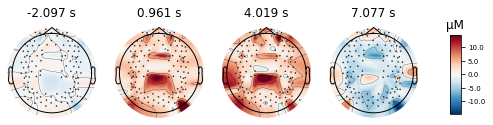

In [758]:
fig_aud_neg = aud_neg.plot_topomap()

fig_aud_neg.savefig('figures_grand_average/aud_neg.pdf')

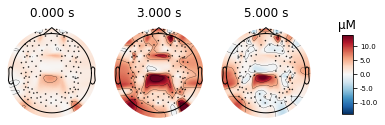

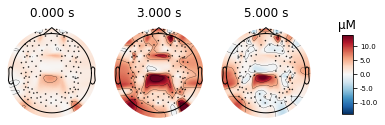

In [824]:
# specifying times
aud_neg.plot_topomap(times=[0, 3, 5], average=3)

In [836]:
# trying to pick channels

roi_vis=[[15,14], [15,15], [14,14], [14,13], [16,14], [16,13], [16,15], [16,16], [29,13], [29,16], [29,28], [31,15], [31,16], [31,30], [30,16], [30,28], [30,30], [30,29], [27,28], [27,29], [32,30], [32,29]
        ], # visual
roi_aud=[[7,4], [7,6], [9,6], [9,8], [9,10], [11,8], [11,10], [11,11], [13,10], [13,11], [13,12], [22,19], [22,21], [22,23], [24,21], [24,23], [24,25], [26,23], [26,25], [26,26], [28,26], [28,25], [28,27] 
         ] #auditory 

In [854]:
roi_vis_hbo = [
    'S15_D14 hbo', 'S15_D15 hbo', 'S14_D14 hbo', 'S14_D13 hbo',
    'S16_D14 hbo', 'S16_D13 hbo', 'S16_D15 hbo', 'S16_D16 hbo', 'S29_D13 hbo', 'S29_D16 hbo', 'S29_D28 hbo', 'S31_D15 hbo', 
    'S31_D16 hbo', 'S31_D30 hbo', 'S30_D16 hbo', 'S30_D28 hbo', 'S30_D30 hbo', 'S30_D29 hbo', 'S27_D28 hbo', 'S27_D29 hbo', 
    'S32_D20 hbo', 'S32_D29 hbo'
]

# roi_vis_hbr = 
# # 'S14_D14 hbr',
# # ,'S15_D15 hbr'


roi_aud_hbo = [
    'S7_D4 hbo', 'S7_D6 hbo', 'S9_D6 hbo', 'S9_D8 hbo', 'S9_D10 hbo',
    'S11_D8 hbo', 'S11_D10 hbo', 'S11 D11 hbo', 'S13_D10 hbo', 'S13_D11 hbo', 
    'S13_D12 hbo', 'S22_D19 hbo', 'S22_D21 hbo', 'S22_D23 hbo', 'S24_D21 hbo', 'S24_D23 hbo', 
    'S24_D25 hbo', 'S26_D23 hbo', 'S26_D25 hbo', 'S26_D26 hbo', 'S28_D26 hbo', 
    'S28_D25 hbo', 'S28_D27 hbo'         
]

# roi_aud = [
#     'S7_D4 hbo',
#    # 'S7_D4 hbr', 
#     'S7_D6 hbo'
#    # ,'S7_D6 hbr'
# ]

In [ ]:
aud_neg.info['ch_names']

In [861]:
vis_ix = mne.pick_channels(aud_neg.info['ch_names'], include = roi_vis_hbo)

aud_ix = mne.pick_channels(aud_neg.info['ch_names'], include = roi_aud_hbo)

In [857]:
vis_ix
aud_ix

array([ 36,  40,  54,  56,  58,  68,  72,  84,  86,  88, 148, 152, 154,
       166, 168, 170, 178, 182, 184, 194, 196, 198])

['ROI1', 'ROI2']


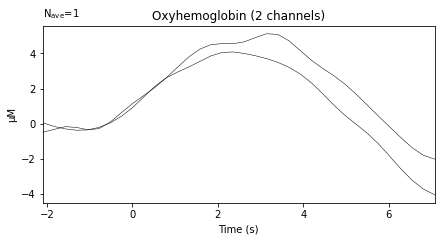

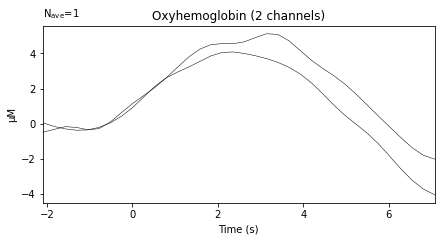

In [863]:
roi_dict = dict(ROI1=vis_ix, ROI2=aud_ix)
roi_evoked = mne.channels.combine_channels(aud_neg, roi_dict, method='mean')
print(roi_evoked.info['ch_names'])
roi_evoked.plot()

In [807]:
type(aud_neg)

<class 'mne.evoked.EvokedArray'>

In [803]:
epochs_aud_neg = df_epochs['Auditory/neg'].average()

AttributeError: 'list' object has no attribute 'average'

In [804]:
type(epochs)

<class 'mne.epochs.Epochs'>

In [805]:
type(df_epochs)

<class 'collections.defaultdict'>

In [808]:
type(all_evokeds)

<class 'collections.defaultdict'>

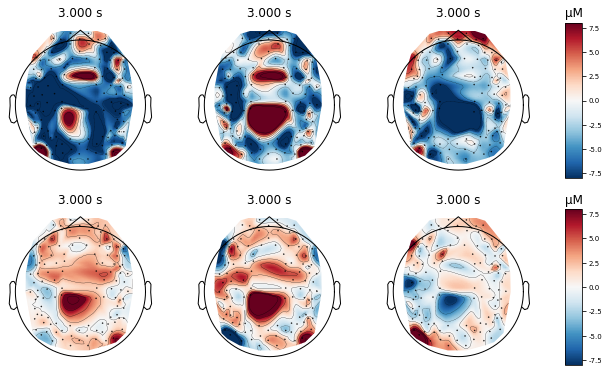

In [742]:
# problem: ikke average, kun på den sidste participant

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 5),
                         gridspec_kw=dict(width_ratios=[1, 1, 1, 0.1]))
vmin, vmax, ts = -8, 8, 3

evoked_vis = epochs['Visual'].average()
evoked_aud = epochs['Auditory'].average()

evoked_vis.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 0],
                        vmin=vmin, vmax=vmax, colorbar=False,
                        **topomap_args, show = False)
evoked_vis.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 0],
                        vmin=vmin, vmax=vmax, colorbar=False,
                        **topomap_args, show = False)
evoked_aud.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 1],
                        vmin=vmin, vmax=vmax, colorbar=False,
                        **topomap_args, show = False)
evoked_aud.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 1],
                        vmin=vmin, vmax=vmax, colorbar=False,
                        **topomap_args, show = False)

evoked_diff = mne.combine_evoked([evoked_vis, evoked_aud], weights=[1, -1])

evoked_diff.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 2:],
                        vmin=vmin, vmax=vmax, colorbar=True,
                        **topomap_args, show = False)
evoked_diff.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 2:],
                        vmin=vmin, vmax=vmax, colorbar=True,
                        **topomap_args)

for column, condition in enumerate(
        ['Visual', 'Auditory', 'Vis-aud']):
    for row, chroma in enumerate(['HbO', 'HbR']):
        axes[row, column].set_title('{}: {}'.format(chroma, condition))
fig.tight_layout()

#fig.savefig('figures_grand_average/average_evoked.pdf')

# Event-related plot

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


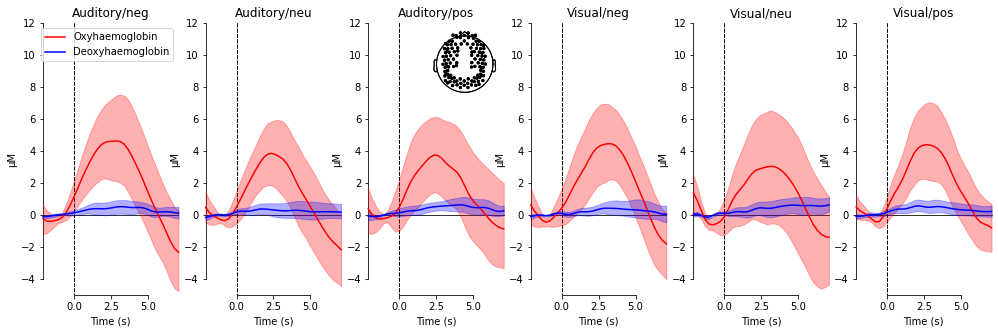

In [870]:
# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(all_evokeds), figsize=(17, 5))
lims = dict(hbo=[-5, 12], hbr=[-5, 12])

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for idx, evoked in enumerate(all_evokeds):
        plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean', #evoked
                             picks=pick, axes=axes[idx], show=False,
                             colors=[color], legend=False, ylim=lims, ci=0.95,
                             show_sensors=idx == 2)
        axes[idx].set_title('{}'.format(evoked))
axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

#fig.savefig("figures_grand_average/all_evokeds.pdf")

# Event-related per ROI

In [864]:
raw_haemo

<RawSNIRF | 2021-10-28_002.snirf, 232 x 10538 (2761.7 s), ~19.0 MB, data loaded>

In [872]:
# Specify channel pairs for each ROI
roi_1=[[15,14], [15,15], [14,14], [14,13], [16,14], [16,13], [16,15], [16,16], [29,13], [29,16], [29,28], [31,15], [31,16], [31,30], [30,16], [30,28], [30,30], [30,29], [27,28], [27,29], [32,30], [32,29]
        ] # visual
roi_2=[[7,4], [7,6], [9,6], [9,8], [9,10], [11,8], [11,10], [11,11], [13,10], [13,11], [13,12], [22,19], [22,21], [22,23], [24,21], [24,23], [24,25], [26,23], [26,25], [26,26], [28,26], [28,25], [28,27] 
        ]#auditory 

# Then generate the correct indices for each pair and store in dictionary
rois = dict(visual_ROI=picks_pair_to_idx(raw_haemo, roi_1, on_missing= 'ignore'),
            auditory_ROI=picks_pair_to_idx(raw_haemo, roi_2, on_missing = 'ignore'))

pprint(rois)

{'auditory_ROI': [36,
                  37,
                  40,
                  41,
                  54,
                  55,
                  56,
                  57,
                  58,
                  59,
                  68,
                  69,
                  72,
                  73,
                  74,
                  75,
                  84,
                  85,
                  86,
                  87,
                  88,
                  89,
                  148,
                  149,
                  152,
                  153,
                  154,
                  155,
                  166,
                  167,
                  168,
                  169,
                  170,
                  171,
                  178,
                  179,
                  182,
                  183,
                  184,
                  185,
                  196,
                  197,
                  194,
                  195,
          

More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, truncating title ...
combining channels using "mean"
More than 6 channels, tru

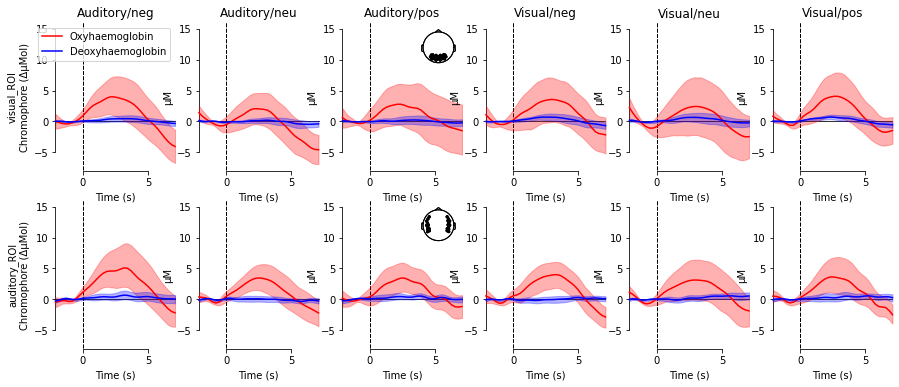

In [874]:
# Specify the figure size and limits per chromophore.
fig, axes = plt.subplots(nrows=len(rois), ncols=len(all_evokeds),
                         figsize=(15, 6))
lims = dict(hbo=[-8, 16], hbr=[-8, 16])

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for ridx, roi in enumerate(rois):
        for cidx, evoked in enumerate(all_evokeds):
            if pick == 'hbr':
                picks = rois[roi][1::2]  # Select only the hbr channels
            else:
                picks = rois[roi][0::2]  # Select only the hbo channels

            plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                                 picks=picks, axes=axes[ridx, cidx],
                                 show=False, colors=[color], legend=False,
                                 ylim=lims, ci=0.95, show_sensors=cidx == 2)
            axes[0, cidx].set_title(f"{evoked}")
            axes[1, cidx].set_title("")
        axes[ridx, 0].set_ylabel(f"{roi}\nChromophore (ΔμMol)")
axes[0, 0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

#fig.savefig("figures_grand_average/all_evokeds_per_cond_ROI.pdf")

In [729]:
print(all_evokeds['Auditory'])
#print(all_evokeds['Auditory'])




[]


In [223]:
# testing
df_aud = all_evokeds['Auditory'][0].to_data_frame()
#df_vis = all_evokeds['Visual'][0].to_data_frame()

df_aud.to_csv("data_frames/df_aud.csv")
df_vis.to_csv("data_frames/df_vis.csv")

# Saving epochs og evokeds

In [692]:
# for loop som laver et dataframe for hvert subject for audition per valence
for idx, sub in enumerate(all_evokeds['Auditory/neg']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_evokeds_aud_neg%d.csv" % idx)

for idx, sub in enumerate(all_evokeds['Auditory/neu']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_evokeds_aud_neu%d.csv" % idx)

for idx, sub in enumerate(all_evokeds['Auditory/pos']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_evokeds_aud_pos%d.csv" % idx)


# for loop som laver et dataframe for hvert subject for visual

for idx, sub in enumerate(all_evokeds['Visual/neg']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_evokeds_vis_neg%d.csv" % idx)

for idx, sub in enumerate(all_evokeds['Visual/neu']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_evokeds_vis_neu%d.csv" % idx)

for idx, sub in enumerate(all_evokeds['Visual/pos']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_evokeds_vis_pos%d.csv" % idx)


# Alba look here

In [693]:
# Saving epochs - Alba look here
# Auditory
for idx, sub in enumerate(df_epochs['Auditory/neg']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_epochs_aud_neg%d.csv" % idx)

for idx, sub in enumerate(df_epochs['Auditory/neu']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_epochs_aud_neu%d.csv" % idx)

for idx, sub in enumerate(df_epochs['Auditory/pos']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_epochs_aud_pos%d.csv" % idx)

# Visual 
for idx, sub in enumerate(df_epochs['Visual/neg']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_epochs_vis_neg%d.csv" % idx)

for idx, sub in enumerate(df_epochs['Visual/neu']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_epochs_vis_neu%d.csv" % idx)

for idx, sub in enumerate(df_epochs['Visual/pos']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_epochs_vis_pos%d.csv" % idx)

In [686]:
for idx, sub in enumerate(df_epochs['Auditory/neg']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_epochs_aud_neg%d.csv" % idx)

for idx, sub in enumerate(df_epochs['Auditory/neu']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_epochs_aud_neu%d.csv" % idx)

for idx, sub in enumerate(df_epochs['Auditory/pos']):
    df_aud = sub.to_data_frame()
    df_aud.to_csv("data_frames/df_epochs_aud_pos%d.csv" % idx)

In [199]:
df_aud = all_evokeds['Auditory'][0].to_data_frame()
df_vis = all_evokeds['Visual'][0].to_data_frame()

df_aud.to_csv("df_aud.csv")
df_vis.to_csv("df_vis.csv")
#df.iloc[:5, :10]

# Individual analysis results
Note, it says group, but it is not group results yet. These results are per person. 

,ROI,Condition,Chroma,theta,se,t,dfe,p,ID,Visual_auditory
0,ROI_1,61,hbo,-27.832662,9.278473,-2.999703,82.0,0.003578,0,Auditory
2,ROI_2,61,hbo,-16.634738,11.705801,-1.421068,82.0,0.159089,0,Auditory
0,ROI_1,62,hbo,-4.336467,9.059609,-0.478659,82.0,0.633455,0,Auditory
2,ROI_2,62,hbo,-14.160358,11.491648,-1.232230,82.0,0.221385,0,Auditory
0,ROI_1,63,hbo,4.477161,8.997792,0.497584,82.0,0.620109,0,Auditory
2,ROI_2,63,hbo,-10.080739,11.444990,-0.880799,82.0,0.381001,0,Auditory
0,ROI_1,70,hbo,-8.523214,9.031705,-0.943699,82.0,0.348096,0,Visual
2,ROI_2,70,hbo,-19.695066,11.421715,-1.724353,82.0,0.088412,0,Visual
0,ROI_1,71,hbo,-16.963097,9.163292,-1.851201,82.0,0.067741,0,Visual
2,ROI_2,71,hbo,-12.136358,11.561066,-1.049761,82.0,0.296912,0,Visual


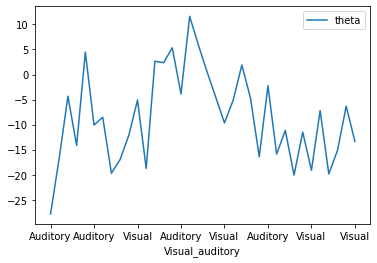

In [231]:
grp_results = df_roi.query("Condition in ['70', '71', '72', '61', '62', '63']")
grp_results = grp_results.query("Chroma in ['hbo']")

#making a new column
grp_results["Visual_auditory"] = np.where(grp_results.Condition.isin(['70', '71', '72']), "Visual", "Auditory")
grp_results.head()

grp_results.plot(x = "Visual_auditory", y = "theta")

grp_results

# GLM 

In [232]:
grp_results = df_roi.query("Condition in ['70', '71', '72', '61', '62', '63']")


#making a new column
grp_results["Visual_auditory"] = np.where(grp_results.Condition.isin(['70', '71', '72']), "Visual", "Auditory")
grp_results.head()

#model
roi_model = smf.mixedlm("theta ~ -1 + ROI:Visual_auditory:Chroma",
                        grp_results, groups=grp_results["ID"]).fit(method='nm')
roi_model.summary()
#grp_results

/var/folders/b0/t62rjb510wb79fxb5ch9n3kc0000gn/T/ipykernel_48652/3532403797.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
=============================================================================================
Model:                          MixedLM             Dependent Variable:             theta    
No. Observations:               72                  Method:                         REML     
No. Groups:                     3                   Scale:                          31.7204  
Min. group size:                24                  Log-Likelihood:                 -213.0380
Max. group size:                24                  Converged:                      Yes      
Mean group size:                24.0                                                         
---------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------------
ROI[ROI_1]:Visual_auditory[Auditory]:Chroma[hbo]  -6.716    3.230 -2.079 0.038 -13.047 -0.386
ROI[ROI_2]:Visual_auditory[Auditory]:Chroma[hbo]  -6.823    3.230 -2.113 0.035 -13.154 -0.493
ROI[ROI_1]:Visual_auditory[Visual]:Chroma[hbo]    -9.230    3.230 -2.858 0.004 -15.561 -2.900
ROI[ROI_2]:Visual_auditory[Visual]:Chroma[hbo]   -11.187    3.230 -3.464 0.001 -17.518 -4.857
ROI[ROI_1]:Visual_auditory[Auditory]:Chroma[hbr]  -1.907    3.230 -0.590 0.555  -8.238  4.423
ROI[ROI_2]:Visual_auditory[Auditory]:Chroma[hbr]  -1.095    3.230 -0.339 0.735  -7.425  5.236
ROI[ROI_1]:Visual_auditory[Visual]:Chroma[hbr]    -2.391    3.230 -0.740 0.459  -8.722  3.940
ROI[ROI_2]:Visual_auditory[Visual]:Chroma[hbr]    -0.483    3.230 -0.149 0.881  -6.813  5.848
Group Var                                         20.725    3.977                            
=============================================================================================

"""

In [48]:
# Saving results
grp_results.to_csv("group_results.csv")

## Epochs   

In [59]:
#renaming triggers
raw_haemo.annotations.rename({'70': 'Visual',
                        '71': 'Visual',
                        '72': 'Visual',
                        '61': 'Auditory',
                        '62': 'Auditory', 
                        '63': 'Auditory'})


<Annotations | 384 segments: 1 (96), 43 (8), 44 (8), 45 (8), 46 (8), 47 ...>

In [32]:
# getting events
events, event_dict = mne.events_from_annotations(raw_haemo)

# signals which are unlikely large are removed
# default 80e-6
# maybe it should be 250e-6
#reject_criteria = dict(hbo=hbo_limit)
tmin, tmax = -2, 7 #time

# getting epochs
epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                    tmin=tmin, tmax=tmax,
                    #reject=reject_criteria, 
                    reject_by_annotation=True,
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=None, verbose=True) 


Used Annotations descriptions: ['1', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '64', '65', '66', '67', '68', '69', '73', '74', '75', '76', '77', '78', 'Auditory', 'Visual']
Not setting metadata
Not setting metadata
384 matching events found
Setting baseline interval to [-2.0968, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 384 events and 36 original time points ...
0 bad epochs dropped


# Plotting
## Entire head

<AxesSubplot:title={'center':'Contrast'}>

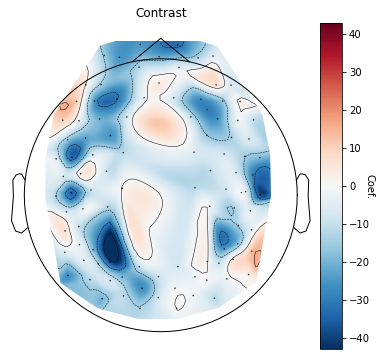

In [233]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
con_summary = df_con.query("Chroma in ['hbo']")

#rois = dict(
#        ROI_1=picks_pair_to_idx(raw_haemo, roi_1, on_missing='ignore'),
#        ROI_2=picks_pair_to_idx(raw_haemo, roi_2, on_missing='ignore'))


# Run group level model and convert to dataframe
con_model = smf.mixedlm("effect ~ -1 + ch_name:Chroma",
                        con_summary, groups=con_summary["ID"]).fit(method='nm')
con_model_df = statsmodels_to_results(con_model,
                                      order=raw_haemo.copy().pick(
                                          picks="hbo").ch_names)

#con_model_df['Coef.'] = -con_model_df['Coef.']

plot_glm_group_topo(raw_haemo.copy().pick(picks="hbo"),
                    con_model_df, colorbar=True, axes=axes)

In [75]:
?df_con.query

Signature: df_con.query(expr: 'str', inplace: 'bool' = False, **kwargs)
Docstring:
Query the columns of a DataFrame with a boolean expression.

Parameters
----------
expr : str
    The query string to evaluate.

    You can refer to variables
    in the environment by prefixing them with an '@' character like
    ``@a + b``.

    You can refer to column names that are not valid Python variable names
    by surrounding them in backticks. Thus, column names containing spaces
    or punctuations (besides underscores) or starting with digits must be
    surrounded by backticks. (For example, a column named "Area (cm^2)" would
    be referenced as ```Area (cm^2)```). Column names which are Python keywords
    (like "list", "for", "import", etc) cannot be used.

    For example, if one of your columns is called ``a a`` and you want
    to sum it with ``b``, your query should be ```a a` + b``.

    .. versionadded:: 0.25.0
        Backtick quoting introduced.

    .. versionadded:: 1.0.0
    

## ROI

In [34]:
topomap_args = dict(extrapolate='local')

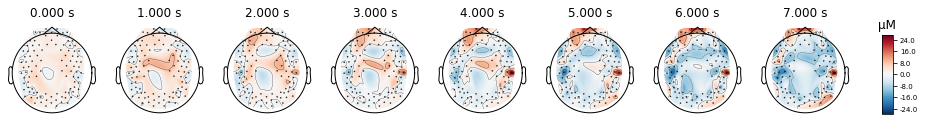

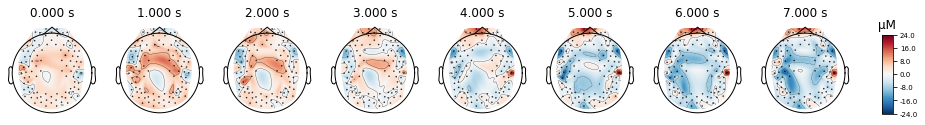

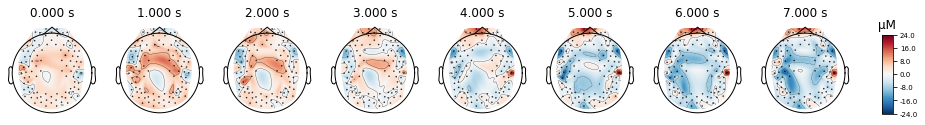

In [43]:
times = np.arange(0, 8, 1)

epochs['Visual'].average(picks='hbo').plot_topomap(
    times=times, **topomap_args)
epochs['Auditory'].average(picks='hbo').plot_topomap(
    times=times, **topomap_args)

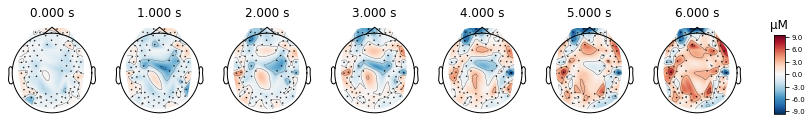

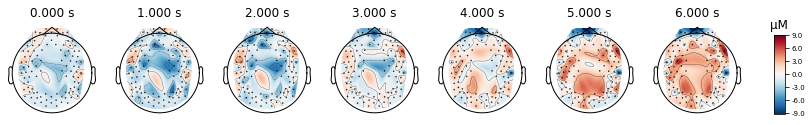

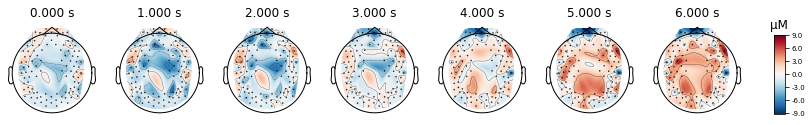

In [38]:
epochs['Visual'].average(picks='hbr').plot_topomap(
    times=times, **topomap_args)
epochs['Auditory'].average(picks='hbr').plot_topomap(
    times=times, **topomap_args)

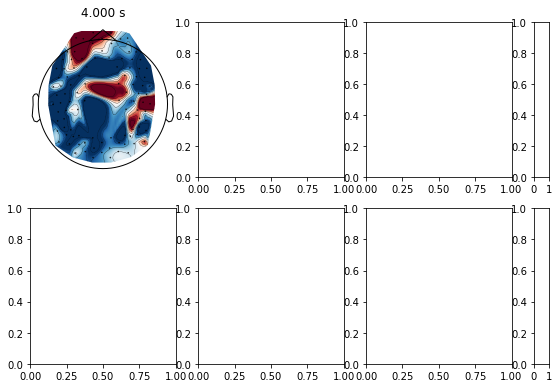

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 5),
                         gridspec_kw=dict(width_ratios=[1, 1, 1, 0.1]))
vmin, vmax, ts = -2.1, 7, 4.0

evoked_vis = epochs['Visual'].average()
evoked_aud = epochs['Auditory'].average()

evoked_vis.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 0],
                         vmin=vmin, vmax=vmax, colorbar=False,
                         **topomap_args)
evoked_vis.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 0],
                         vmin=vmin, vmax=vmax, colorbar=False,
                         **topomap_args)
evoked_aud.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 1],
                          vmin=vmin, vmax=vmax, colorbar=False,
                          **topomap_args)
evoked_aud.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 1],
                          vmin=vmin, vmax=vmax, colorbar=False,
                          **topomap_args)

evoked_diff = mne.combine_evoked([evoked_vis, evoked_aud], weights=[1, -1])

evoked_diff.plot_topomap(ch_type='hbo', times=ts, axes=axes[0, 2:],
                         vmin=vmin, vmax=vmax, colorbar=True,
                         **topomap_args)
evoked_diff.plot_topomap(ch_type='hbr', times=ts, axes=axes[1, 2:],
                         vmin=vmin, vmax=vmax, colorbar=True,
                         **topomap_args)

for column, condition in enumerate(
        ['Visual', 'Auditory', 'Vis-aud']):
    for row, chroma in enumerate(['HbO', 'HbR']):
        axes[row, column].set_title('{}: {}'.format(chroma, condition))
fig.tight_layout()